In [ ]:
import logging
import os
import json

import random
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:
config = dict()
config['DATASET'] = 'CIFAR10' #CIFAR10, CIFAR100, FashionMNIST etc.
config['TEST_SIZE'] = 0.3
config['AUG_NOISE_P'] = 0.0
config['AUG_NOISE_VAL'] = 0.0
config['NUM_WORKERS'] = 0
config['BATCH_SIZE'] = 128
config['LR'] = 0.003
config['DEVICE'] = 'cuda:0'
config['ARTIFACTS_FOLDER'] = ''
config['NUM_EPOCHS'] = 2
config['SEED'] = 333

In [ ]:
def get_dataset(name, train=True):
  data = datasets.__dict__[name]('../data', train=train, download=True)  
  images = np.array(data.data).astype('float32')
  labels = np.array(data.targets).astype('int64')
  images = np.transpose(images, axes=(0, 3, 1, 2))
  return images, labels

class CVDataset(Dataset):
  def __init__(self, images, labels, config, train=True):
    self.images = images
    self.labels = labels 
    self.config = config
    self.train = train

    self.mean = np.array(config['PP_MEAN'])[:, None, None]
    self.std = np.array(config['PP_STD'])[:, None, None]

  def __len__(self):
    return self.images.shape[0]

  def __getitem__(self, index):
    image = self.images[index]
    label = self.labels[index]

    image = self.preprocess(image)

    if self.train:
      image = self.augmentations(image)

    return image, label

  def preprocess(self, image):
    image = image - self.mean
    image /= self.std
    return image.astype('float32')

  def augmentations(self, image):
    if np.random.random() < self.config['AUG_NOISE_P']:
      image += np.random.randn(*image.shape) * self.config['AUG_NOISE_VAL']
    return image

In [ ]:
class Net(nn.Module): #https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def number_of_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)
    
def create_net(config):
  net = Net(config['INPUT_SHAPE'], config['NUM_CLASSES'])
  return net

def get_mean_and_std(net):
  val = list()
  for p in net.parameters():
    val.append(p.data.view(-1))
  val = torch.cat(val)
  return val.mean().item(), val.std().item()

def plot_weight_hists(net, size=3):
  p_list = list(net.parameters())
  to_show = len(p_list)
  plt.figure(figsize=(to_show * size, size))
  for i, p in enumerate(p_list):
    plt.subplot(1, to_show, i + 1)
    plt.hist(p.data.view(-1).detach().cpu().numpy(), bins=20)
  plt.show()


def plot_grad_hists(net, size=3):
  p_list = list(net.parameters())
  to_show = len(p_list)
  plt.figure(figsize=(to_show * size, size))
  for i, p in enumerate(p_list):
    plt.subplot(1, to_show, i + 1)
    plt.hist(p.grad.view(-1).detach().cpu().numpy(), bins=20)
  plt.show()



In [ ]:
def train_net(net, dl, criterion, optimizer, device='cpu'):
  net.to(device)
  net.train()

  losses = list()
  for images, labels in tqdm(dl):

    images = images.to(device)
    labels = labels.to(device)

    logits = net(images)  
    loss = criterion(logits, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

  return net, losses

def validate_net(net, dl, device='cpu'):
  net.to(device)
  net.eval()

  dl_labels = list()
  dl_logits = list()
  for images, labels in tqdm(dl):

    images = images.to(device)
    with torch.no_grad():   
      logits = net(images)

    dl_labels.append(labels.cpu().numpy())
    dl_logits.append(logits.detach().cpu().numpy())

  dl_labels = np.concatenate(dl_labels)
  dl_logits = np.concatenate(dl_logits)

  preds = np.argmax(dl_logits, axis=1)

  metrics = dict()
  metrics['accuracy'] = (dl_labels == preds).mean()

  for class_id in range(dl_labels.max() + 1):
    class_labels = dl_labels == class_id
    class_preds = preds == class_id

    metrics[f'{class_id}_true_freq'] = class_labels.mean()
    metrics[f'{class_id}_pred_freq'] = class_preds.mean()
    metrics[f'{class_id}_f1'] = f1_score(class_labels, class_preds)

  print('Prediction histogram')
  plt.figure(figsize=(5, 5))
  plt.hist(preds, bins=dl_labels.max() + 1)
  plt.show()

  print('Prediction histogram')
  plt.figure(figsize=(5, 5))
  plt.hist(dl_logits.flatten(), bins=100)
  plt.show()


  return metrics


def plot_sample(dl, to_show=10, size=3):
  images, labels = next(iter(dl))
#  plt.figure(figsize=(to_show * size, size))
#  for i in range(to_show):
#    plt.subplot(1, to_show, i + 1)
#    im = np.transpose(images[i].numpy(), axes=(1, 2, 0))
#    im = im - im.min()
#    im = im / im.max()
#    plt.imshow(im)
#  plt.show()

  plt.figure(figsize=(to_show * size, size))
  for i in range(to_show):
    plt.subplot(1, to_show, i + 1)
    im = images[i].numpy().flatten()
    plt.hist(im, bins=20)
  plt.show()

  print(labels)


In [ ]:
def pipeline(config):

  torch.manual_seed(config['SEED'])
  np.random.seed(config['SEED'])
  random.seed(config['SEED'])



  images, labels = get_dataset(config['DATASET'], train=True)

  logging.info(f'Images shape: {images.shape}')
  logging.info(f'Labels shape: {labels.shape}')
  for class_id in np.unique(labels):
    logging.info(f'Class id: {class_id}. Class freq: {(labels == class_id).mean()}')
  
  train_images, valid_images, train_labels, valid_labels = train_test_split(images, labels, test_size=config['TEST_SIZE'], random_state=config['SEED'])
  
  logging.info(f'Train size: {train_images.shape[0]}')
  logging.info(f'Valid size: {valid_images.shape[0]}')

  config['PP_MEAN'] = [float(val) for val in train_images.mean(axis=(0, 2, 3))]
  config['PP_STD'] = [float(val) for val in train_images.std(axis=(0, 2, 3))]

  logging.info(f'Preprocessing mean: {config["PP_MEAN"]}')
  logging.info(f'Preprocessing std: {config["PP_STD"]}')

  train_ds = CVDataset(train_images, train_labels, config, train=True)
  valid_ds = CVDataset(valid_images, valid_labels, config, train=False)

  train_dl = DataLoader(train_ds, batch_size=config['BATCH_SIZE'], num_workers=config['NUM_WORKERS'], shuffle=True)
  valid_dl = DataLoader(valid_ds, batch_size=config['BATCH_SIZE'], num_workers=config['NUM_WORKERS'], shuffle=False)

  plot_sample(train_dl)
  plot_sample(valid_dl)

  config['NUM_CLASSES'] = int(np.max(labels) + 1)
  config['INPUT_SHAPE'] = [int(val) for val in train_images[0].shape]

  net = create_net(config)

  logging.info(f'Net: {net.__str__()}')
  logging.info(f'Number of parameters: {number_of_parameters(net)}')
  
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=config['LR'])

  history = list()
  train_loss = list()

  train_metrics = validate_net(net, train_dl, device=config['DEVICE'])
  valid_metrics = validate_net(net, valid_dl, device=config['DEVICE'])

  logging.info(f'Untrained train metrics: {train_metrics}')
  logging.info(f'Untrained valid metrics: {valid_metrics}')

  for epoch in range(config['NUM_EPOCHS']):

    logging.info(f'Epoch number: {epoch} starts')
    plot_weight_hists(net)
    net, epoch_loss = train_net(net, train_dl, criterion, optimizer, device=config['DEVICE'])
    train_loss += epoch_loss
    plot_grad_hists(net)
    logging.info(f'Mean and std of Net: {get_mean_and_std(net)}')
    
    plt.figure(figsize=(10, 3))
    plt.plot(train_loss)
    plt.show()

    train_metrics = validate_net(net, train_dl, device=config['DEVICE'])
    valid_metrics = validate_net(net, valid_dl, device=config['DEVICE'])

    epoch_history = dict()
    epoch_history['train_loss'] = np.mean(train_loss)
    epoch_history.update({f'train_{key}': val for key, val in train_metrics.items()})
    epoch_history.update({f'valid_{key}': val for key, val in valid_metrics.items()})
    history.append(epoch_history)

    log_file = os.path.join(config['ARTIFACTS_FOLDER'], 'history.csv')
    weights_file = os.path.join(config['ARTIFACTS_FOLDER'], 'net_weights.pt')
    config_file = os.path.join(config['ARTIFACTS_FOLDER'], 'config.cfg')

    pd.DataFrame(history).to_csv(log_file)
    torch.save(net, weights_file)
    with open(config_file, 'w') as f:
      json.dump(config, f)

Files already downloaded and verified


INFO:root:Images shape: (50000, 3, 32, 32)
INFO:root:Labels shape: (50000,)
INFO:root:Class id: 0. Class freq: 0.1
INFO:root:Class id: 1. Class freq: 0.1
INFO:root:Class id: 2. Class freq: 0.1
INFO:root:Class id: 3. Class freq: 0.1
INFO:root:Class id: 4. Class freq: 0.1
INFO:root:Class id: 5. Class freq: 0.1
INFO:root:Class id: 6. Class freq: 0.1
INFO:root:Class id: 7. Class freq: 0.1
INFO:root:Class id: 8. Class freq: 0.1
INFO:root:Class id: 9. Class freq: 0.1
INFO:root:Train size: 35000
INFO:root:Valid size: 15000
INFO:root:Preprocessing mean: [125.25171661376953, 122.84329986572266, 113.69769287109375]
INFO:root:Preprocessing std: [62.95351791381836, 62.09902572631836, 66.73350524902344]


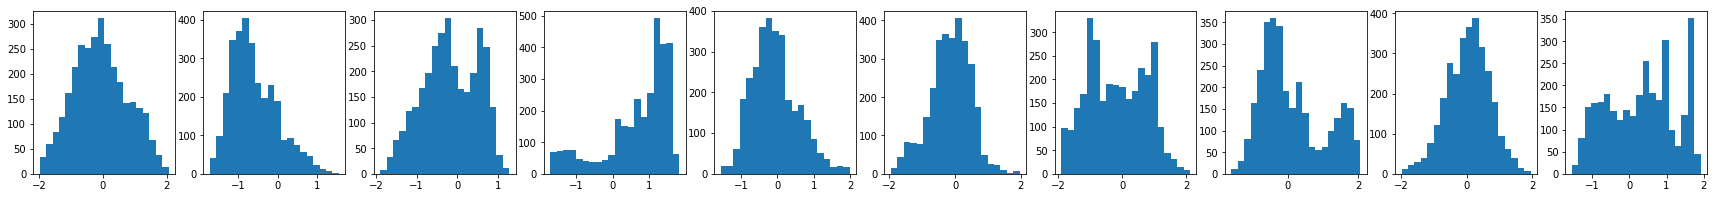

tensor([3, 4, 7, 0, 9, 5, 1, 4, 4, 6, 5, 0, 9, 9, 9, 3, 9, 4, 1, 0, 5, 9, 4, 2,
        5, 5, 2, 3, 8, 7, 3, 4, 2, 4, 3, 3, 9, 3, 6, 4, 8, 4, 3, 0, 3, 0, 3, 8,
        1, 7, 7, 5, 3, 9, 9, 5, 6, 7, 2, 2, 7, 9, 4, 1, 7, 6, 8, 8, 6, 8, 7, 2,
        8, 0, 9, 9, 9, 5, 6, 2, 5, 3, 7, 0, 2, 7, 9, 1, 2, 9, 2, 3, 9, 5, 1, 8,
        7, 8, 0, 3, 0, 1, 2, 9, 1, 8, 2, 2, 4, 4, 5, 0, 8, 9, 1, 4, 3, 1, 8, 0,
        8, 1, 7, 8, 0, 2, 4, 9])


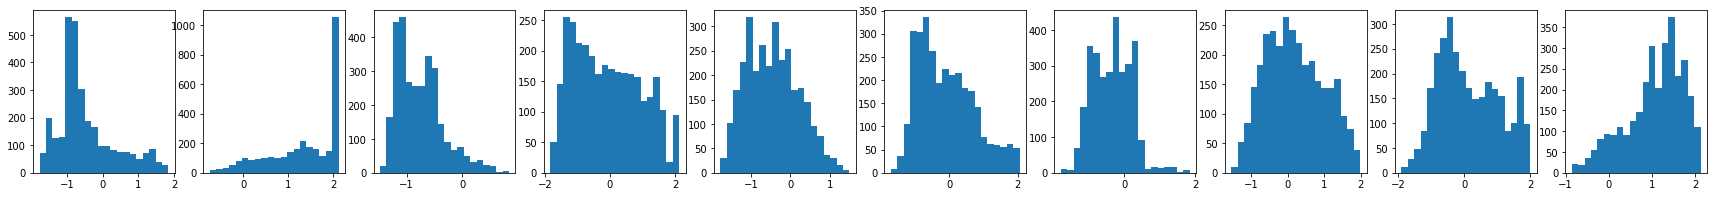

INFO:root:Net: Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
INFO:root:Number of parameters: 62006


tensor([2, 0, 3, 9, 6, 5, 2, 3, 9, 8, 0, 3, 3, 5, 8, 1, 2, 6, 7, 8, 0, 3, 6, 8,
        0, 9, 3, 4, 9, 6, 5, 9, 3, 6, 7, 6, 3, 0, 1, 0, 9, 9, 2, 5, 7, 2, 2, 4,
        1, 3, 0, 3, 9, 3, 7, 1, 5, 2, 6, 2, 0, 7, 0, 7, 3, 7, 0, 6, 8, 7, 0, 5,
        0, 5, 7, 8, 9, 2, 2, 2, 9, 7, 8, 9, 8, 0, 7, 4, 6, 3, 8, 6, 2, 7, 8, 8,
        3, 4, 2, 7, 4, 8, 4, 2, 0, 9, 4, 7, 2, 6, 4, 9, 8, 1, 7, 2, 6, 0, 0, 5,
        6, 9, 8, 6, 3, 5, 6, 7])


100%|██████████| 274/274 [00:05<00:00, 53.49it/s] 


Prediction histogram


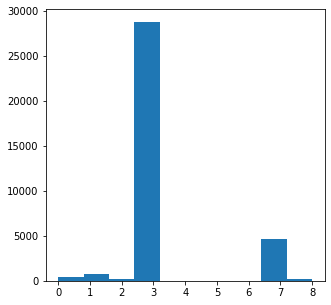

Prediction histogram


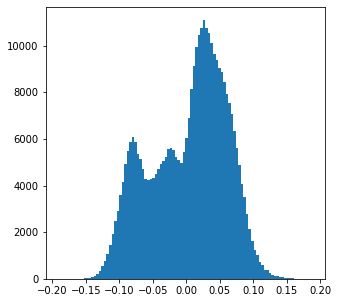

100%|██████████| 118/118 [00:01<00:00, 74.54it/s]


Prediction histogram


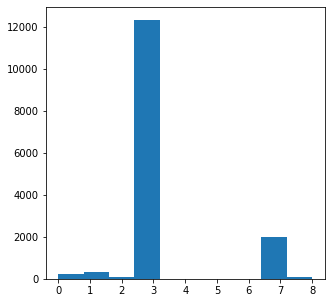

Prediction histogram


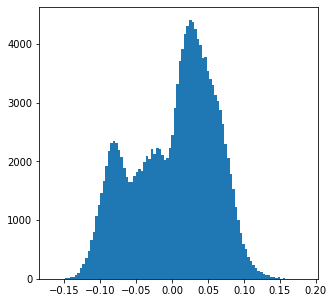

INFO:root:Untrained train metrics: {'accuracy': 0.0898, '0_true_freq': 0.09837142857142857, '0_pred_freq': 0.012342857142857143, '0_f1': 0.013935483870967743, '1_true_freq': 0.09945714285714286, '1_pred_freq': 0.02177142857142857, '1_f1': 0.016026396417629037, '2_true_freq': 0.10228571428571429, '2_pred_freq': 0.004771428571428571, '2_f1': 0.012810248198558848, '3_true_freq': 0.09882857142857143, '3_pred_freq': 0.8225142857142858, '3_f1': 0.16460445932955006, '4_true_freq': 0.09894285714285714, '4_pred_freq': 0.0006285714285714285, '4_f1': 0.0005738880918220948, '5_true_freq': 0.10022857142857143, '5_pred_freq': 0.0, '5_f1': 0.0, '6_true_freq': 0.1018, '6_pred_freq': 0.0, '6_f1': 0.0, '7_true_freq': 0.09977142857142857, '7_pred_freq': 0.13185714285714287, '7_f1': 0.08930553842358456, '8_true_freq': 0.1004, '8_pred_freq': 0.0061142857142857145, '8_f1': 0.021995708154506438, '9_true_freq': 0.09991428571428572, '9_pred_freq': 0.0, '9_f1': 0.0}
INFO:root:Untrained valid metrics: {'accuracy

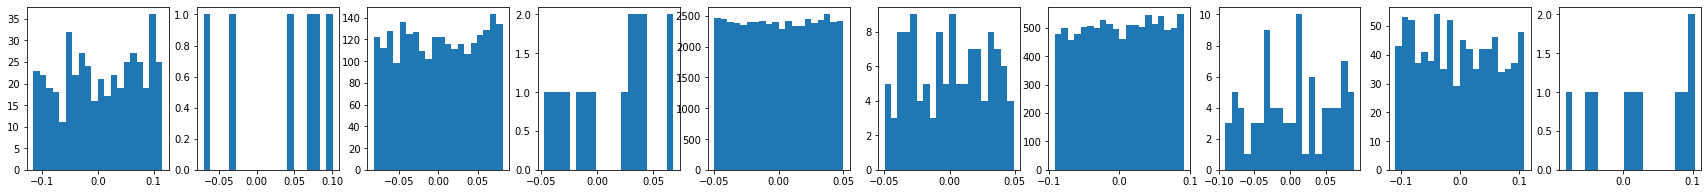

100%|██████████| 274/274 [00:03<00:00, 72.73it/s] 


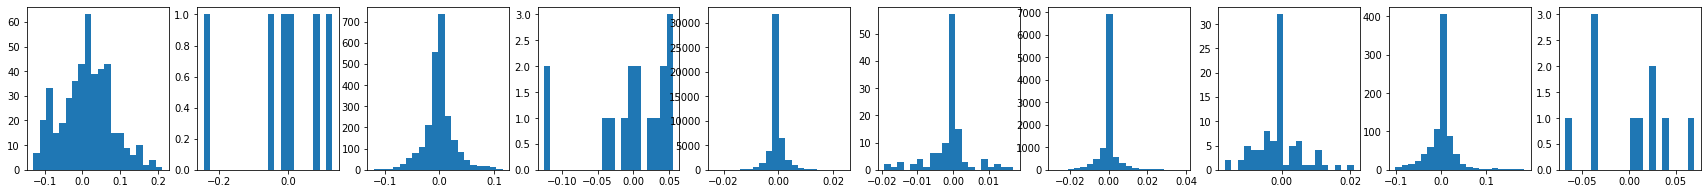

INFO:root:Mean and std of Net: (-0.005799633450806141, 0.05639046058058739)


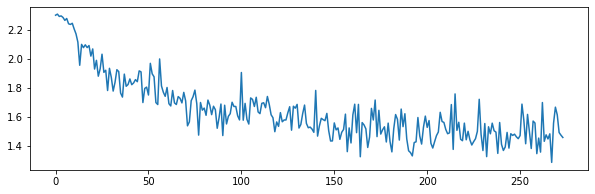

100%|██████████| 274/274 [00:01<00:00, 185.61it/s]


Prediction histogram


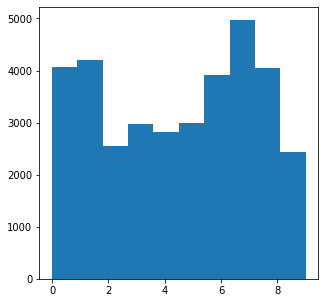

Prediction histogram


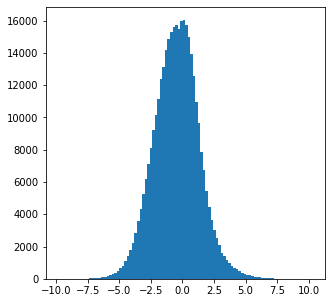

100%|██████████| 118/118 [00:00<00:00, 231.92it/s]


Prediction histogram


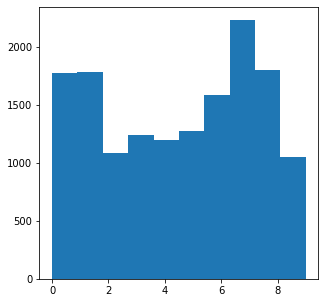

Prediction histogram


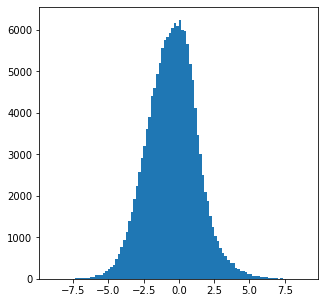

INFO:root:Epoch number: 1 starts


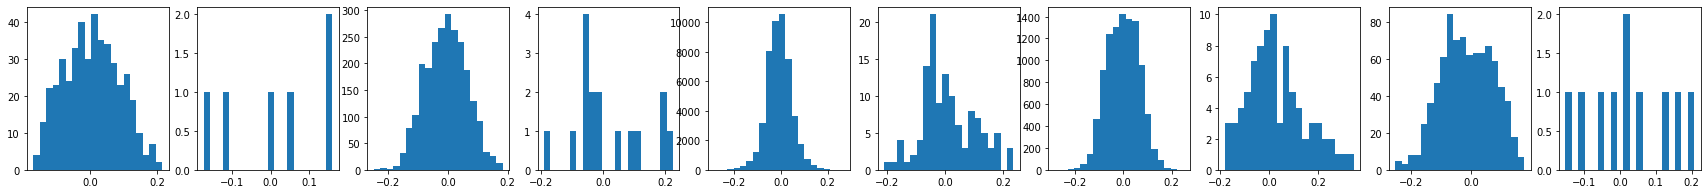

100%|██████████| 274/274 [00:01<00:00, 137.26it/s]


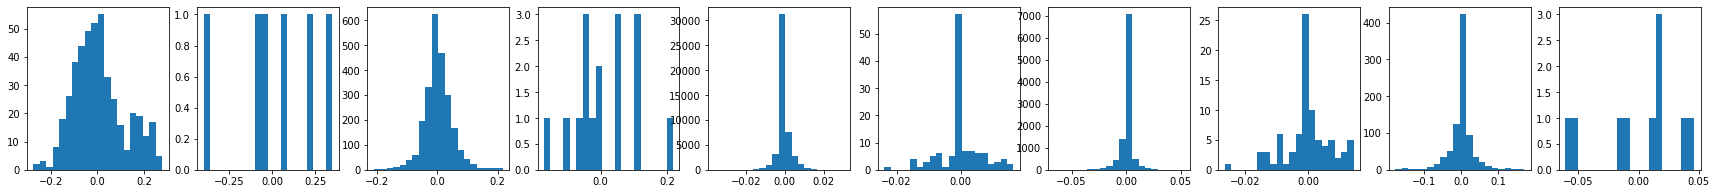

INFO:root:Mean and std of Net: (-0.00812353566288948, 0.06919132173061371)


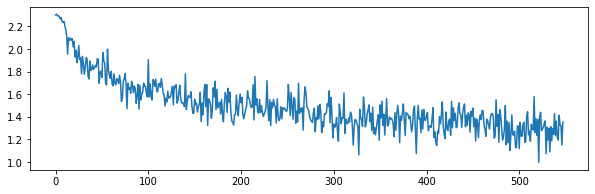

100%|██████████| 274/274 [00:01<00:00, 216.11it/s]


Prediction histogram


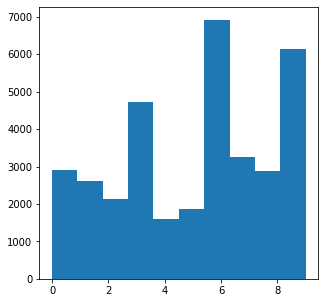

Prediction histogram


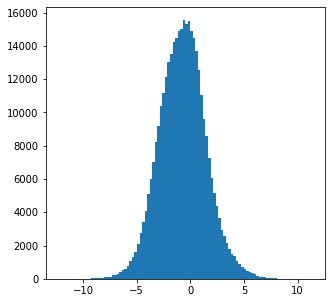

100%|██████████| 118/118 [00:01<00:00, 117.84it/s]


Prediction histogram


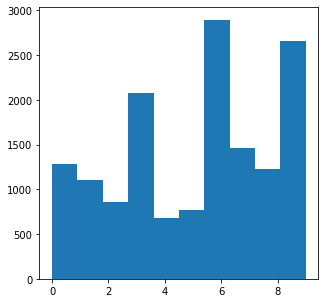

Prediction histogram


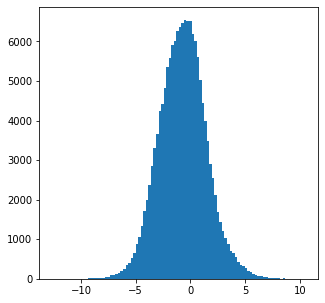

In [ ]:
pipeline(config)

In [ ]:
!ls -lah

total 272K
drwxr-xr-x 1 root root 4.0K Nov 11 10:36 .
drwxr-xr-x 1 root root 4.0K Nov 11 10:35 ..
drwxr-xr-x 4 root root 4.0K Nov  9 14:28 .config
-rw-r--r-- 1 root root  395 Nov 11 10:50 config.cfg
-rw-r--r-- 1 root root 3.2K Nov 11 10:50 history.csv
-rw-r--r-- 1 root root 247K Nov 11 10:50 net_weights.pt
drwxr-xr-x 1 root root 4.0K Nov  9 14:29 sample_data


In [ ]:
history = pd.read_csv('history.csv', index_col=0)

In [ ]:
history

,train_loss,train_accuracy,train_0_true_freq,train_0_pred_freq,train_0_f1,train_1_true_freq,train_1_pred_freq,train_1_f1,train_2_true_freq,train_2_pred_freq,...,valid_6_f1,valid_7_true_freq,valid_7_pred_freq,valid_7_f1,valid_8_true_freq,valid_8_pred_freq,valid_8_f1,valid_9_true_freq,valid_9_pred_freq,valid_9_f1
0,1.643390,0.486714,0.098371,0.116257,0.500000,0.099457,0.120257,0.615605,0.102286,0.073114,...,0.564527,0.100533,0.148667,0.511503,0.099067,0.119733,0.565509,0.1002,0.069667,0.456829
1,1.495858,0.532171,0.098371,0.082943,0.579893,0.099457,0.074514,0.633930,0.102286,0.060971,...,0.540291,0.100533,0.097200,0.581254,0.099067,0.082200,0.650975,0.1002,0.176933,0.564830
